In [9]:
import pandas as pd
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt

/tmp/ipykernel_29568/424517169.py:22: RuntimeWarning: Mean of empty slice
  sunshine['Radiation_mean'] = np.nanmean(tt, axis=1)
/mnt/DATA1/wuliubin/miniconda3/envs/metro/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


<Figure size 864x432 with 0 Axes>

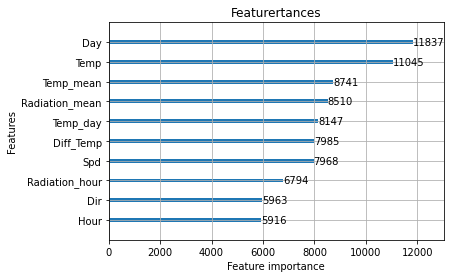

In [10]:
Mode = 'Train'
point = 600
by_day = False

sunshine = pd.read_csv("Dataset/sunshine.csv")
temp = pd.read_csv("Dataset/temp.csv")
wind = pd.read_csv("Dataset/wind.csv")
# temp['Temp'][-720:] = temp['Temp'][-720:] +0.15
# sunshine = sunshine.drop(sunshine[sunshine.Day <200].index)
# temp['Temp_level'] = temp['Day'].apply(lambda x: 1 if x < 95 else 1 if x > 280 else 0)

# 近五日均温
window = np.array([-2, -1, 0, 1, 2])
tt = np.zeros((len(temp), len(window)))
for i in np.arange(len(window)):
    tt[:, i] = temp['Temp'].shift(24*window[i])
temp['Temp_mean'] = np.nanmean(tt, axis=1)

# 前十日平均产量
window = np.arange(10) + 10
tt = np.zeros((len(sunshine), len(window)))
for i in np.arange(len(window)):
    tt[:, i] = sunshine['Radiation'].shift(24*window[i])
sunshine['Radiation_mean'] = np.nanmean(tt, axis=1)

# 日均温
Temp_day = temp.groupby(['Day'])['Temp'].mean().to_frame('Temp_day').reset_index()
Temp_day['Diff_Temp'] = Temp_day['Temp_day'].diff()
# wind['Dir_cos'] = np.cos(wind['Dir'] * np.pi / 180)
# wind['Dir_sin'] = np.sin(wind['Dir'] * np.pi / 180)

# 小时平均产量
sunshine = sunshine.merge(sunshine.groupby(['Hour'])['Radiation'].mean().to_frame('Radiation_hour'), on='Hour', how='left')


if Mode == 'Train':
    train_data = sunshine[0:-point].merge(temp, on=['Day', 'Hour'], how='left')
    train_data = train_data.merge(wind, on=['Day', 'Hour'], how='left')
    val_data = sunshine[-point:].merge(temp, on=['Day', 'Hour'], how='left')
    val_data = val_data.merge(wind, on=['Day', 'Hour'], how='left')
    pre_data = val_data.copy()

elif Mode == 'Pred':
    train_data = sunshine.merge(temp, on=['Day', 'Hour'], how='left')
    train_data = train_data.merge(wind, on=['Day', 'Hour'], how='left')
    val_data = train_data.copy()
    sunshine1 = sunshine.iloc[0:150, :]
    sunshine1['Day'] = sunshine1['Day'].map(lambda x: x + 300)
    pre_data = sunshine1.merge(temp, on=['Day', 'Hour'], how='left')
    pre_data = pre_data.merge(wind, on=['Day', 'Hour'], how='left')
    pre_data['Radiation'] = 0

train_data = train_data.merge(Temp_day, on=['Day'], how='left')
val_data = val_data.merge(Temp_day, on=['Day'], how='left')
pre_data = pre_data.merge(Temp_day, on=['Day'], how='left')

if by_day:
    train_data = train_data.groupby(['Day']).mean().reset_index()
    val_data = val_data.groupby(['Day']).mean().reset_index()
    pre_data = pre_data.groupby(['Day']).mean().reset_index()
    
features = [f for f in train_data.columns if f not in ['Radiation']]

# params = {
#     'boosting': 'gbdt',
#     'objective': 'huber',
#     'num_leaves': 52,
#     'learning_rate': 0.07,
#     'metric': {'mse'},
#     'verbose': -1,
#     'min_data_in_leaf': 5,
#     'max_depth':10,
#     'seed':42, 
#     'num_iterations': 300,
#     'sub_feature': 0.7, 
# }
params = {
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 2**7-1,
    'learning_rate': 0.01,
    'metric': {'mse'},
    'verbose': -1,
    'min_data_in_leaf': 3,
    'max_depth':7,
    'seed':42, 
    'num_iterations': 1000,
    'sub_feature': 0.7, 
}


lgb_train = lgb.Dataset(train_data[features], train_data['Radiation'].values)
# lgb_eval = lgb.Dataset(val_data[features], val_data['Radiation'].values, reference=lgb_train)

# if Mode ==  'Train':
#     gbm = lgb.train(params,
#                     train_set=lgb_train,
#                     valid_sets=lgb_eval,
#                     callbacks=[lgb.early_stopping(stopping_rounds=300)], )
if Mode ==  'Train':
    gbm = lgb.train(params,
                    train_set=lgb_train,)
elif Mode == 'Pred':
    gbm = lgb.train(params,
                train_set=lgb_train)


# 预测提交数据
Y_pred = gbm.predict(pre_data[features])
Y_train = gbm.predict(train_data[features])

plt.figure(figsize=(12, 6))
lgb.plot_importance(gbm, max_num_features=20)
plt.title("Featurertances")
plt.show()

train_error: 0.0007153462493810342
val_error: 0.014660329793011084


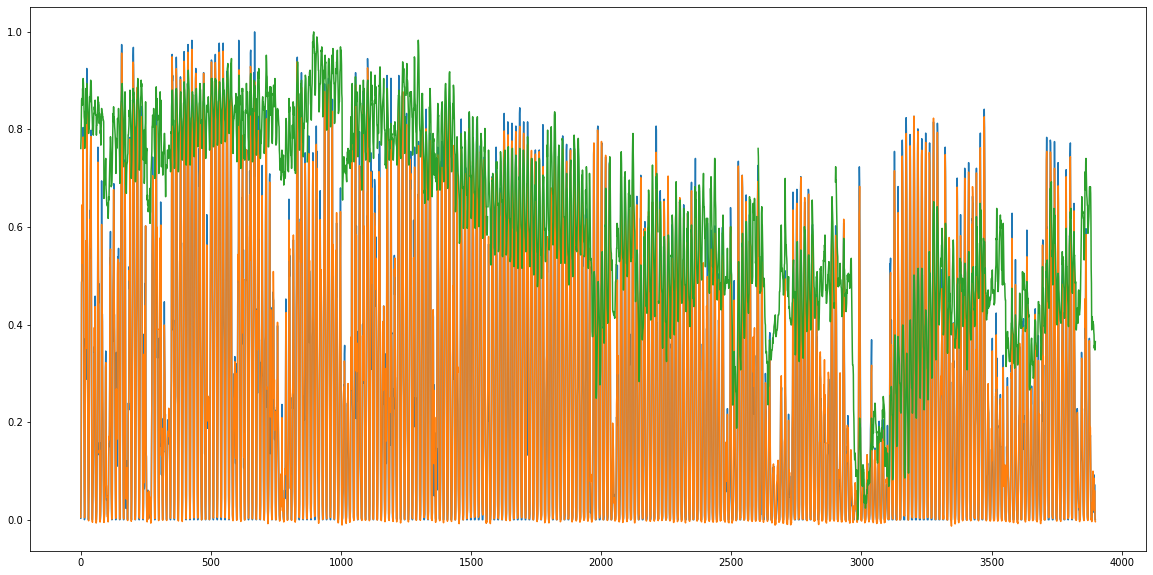

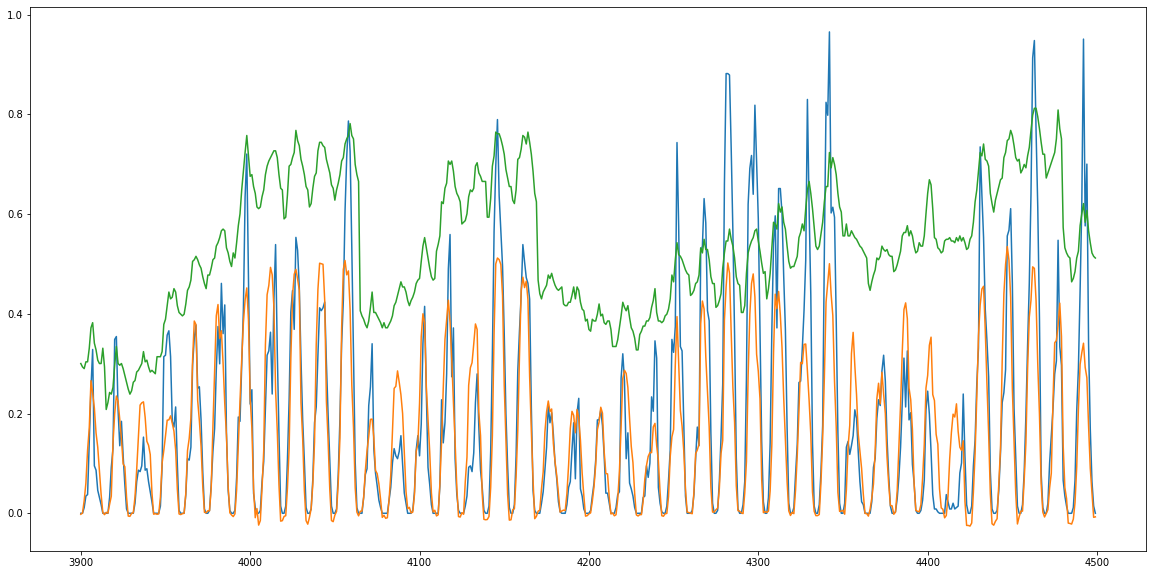

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(train_data['Radiation'])
plt.plot(Y_train, label='pred')
plt.plot(train_data['Temp'])
# plt.plot(train_data['Spd'])
# plt.figure(figsize=(20, 10))

plt.figure(figsize=(20, 10))
plt.plot(np.arange(3900, 4500), pre_data['Radiation'])
plt.plot(np.arange(3900, 4500), Y_pred)
plt.plot(np.arange(3900, 4500), pre_data['Temp'])
# plt.plot(val_data['Spd'])

# plt.plot(np.arange(4500, 4650), pre_data['Radiation'])
# plt.plot(np.arange(4500, 4650), Y_pred)
# plt.plot(np.arange(4500, 4650), pre_data['Temp'])
# plt.plot(np.arange(4500, 4650), pre_data['Temp_level'])

from sklearn.metrics import mean_squared_error
print('train_error:', mean_squared_error(train_data['Radiation'], Y_train))
print('val_error:', mean_squared_error(pre_data['Radiation'], Y_pred))

In [12]:
dataframe = pd.DataFrame({'Radiation': Y_pred})
dataframe.to_csv("Dataset/Y_pred.csv", index=False, sep=',')